In [1]:
from google.colab import drive
drive.mount("./content")

Mounted at ./content


In [2]:
cd /content/content/MyDrive/Keras/Project/Image_Captioning


/content/content/MyDrive/Keras/Project/Image_Captioning


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string # want to use string.punctuation to preprocessing text
import os
from PIL import Image
import glob # use to take all image in folder
from pickle import dump, load # save and load the model
from time import time # take time for each process

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, \
                          Activation, Flatten, Reshape, concatenate, \
                          Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import Add
from keras.models import Model
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [4]:
def load_doc(filename):
  """
  Task: Read these file has format .txt
  Args: string(filename)
  Return string

  """

  # open the file as read only
  file = open(filename, 'r')

  # read all text
  text = file.read()
  file.close()
  return text

In [5]:
if os.path.exists("Flickr8k") and os.listdir("Flickr8k"):
    print("Thư mục Flickr8k đã tồn tại và không cần tải dữ liệu xuống")
else:
    print("Đang tải dữ liệu xuống.........")
    # Thực hiện tải xuống
    !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
    !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
    !unzip -qq -n Flickr8k_Dataset.zip -d Flickr8k
    !unzip -qq -n Flickr8k_text.zip -d Flickr8k
    !rm Flickr8k_Dataset.zip Flickr8k_text.zip

Thư mục Flickr8k đã tồn tại và không cần tải dữ liệu xuống


In [6]:
"""
file Flicker8k.token.txt will contain many rows and each rows will include 2 part separated '\n'
part 1: Name photo because each photo has 5 descriptions so we has name photo and # their order begin 1 - 5
part 2: Each name photo will has 1 correspond descriptions with it
"""

filename = "Flickr8k/Flickr8k.token.txt" # this file contain
doc = load_doc(filename)
print(doc[:550]) # display 1 photo and the correspond descriptions with it

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playin


In [7]:
def load_desciptions(doc):
  """
  Task: Load these description with corresponding photo
  Args: String(doc)
  Return: dict with key is name photo with remove .jpg#number and
          value is these desciptions of it
  """
  mapping = dict()

  for line in doc.split("\n"): # line is one rows
    tokens = line.split() # line is list has 2 elements

    if len(tokens) < 2: # ignore if line only has 1 element
      continue

    image_id, image_desc = tokens[0], tokens[1:]

    image_id = image_id.split('.')[0]

    image_desc = ' '.join(image_desc)

    if image_id not in mapping:
      mapping[image_id] = list()

    mapping[image_id].append(image_desc)

  return mapping

descriptions = load_desciptions(doc)
print('Loaded: %d' % len(descriptions))
print(descriptions)


Output hidden; open in https://colab.research.google.com to view.

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
def clean_descriptions(descriptions):

  """
  Task:
  Args:
  Return

  """
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each tokens
      desc = [word.translate(table) for word in desc]
      # store as string
      desc_list[i] = ' '.join(desc)

clean_descriptions(descriptions)
print(descriptions.values())


Output hidden; open in https://colab.research.google.com to view.

In [10]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
# save description to file

def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)

    data = "\n".join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
save_descriptions(descriptions, 'descriptions.txt')

In [12]:
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()

  for line in doc.split('\n'):
    if len(line) < 1:
      continue
    identifier = line.split('.')[0]
    dataset.append(identifier)

  return set(dataset)



In [13]:
filenametraintxt = "Flickr8k/Flickr_8k.trainImages.txt"
train = load_set(filenametraintxt)
print('Dataset: %d' %len(train)) # has 6000 photo for train

Dataset: 6000


In [14]:
images  = 'Flickr8k/Flicker8k_Dataset/'

img = glob.glob(images + "*.jpg") # All path point to the Photo
print(len(img)) # has 8091 photo

8091


In [15]:
train_image_file = 'Flickr8k/Flickr_8k.trainImages.txt'
# name photo
train_images = set(open(train_image_file, 'r').read().strip().split('\n'))
len(train_images)

6000

In [16]:
train_img = []

for photo in img:
  if photo[len(images):] in train_images:
    train_img.append(photo)

test_images_file = 'Flickr8k/Flickr_8k.testImages.txt'
test_images =  set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for photo in img:
  if photo[len(images):] in test_images:
    test_img.append(photo)


In [17]:
def load_clean_descriptions(filename, dataset):


  """
  Task:
  Args:
  Return:
  """

  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    tokens = line.split()

    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in dataset:

        if image_id not in descriptions:

            descriptions[image_id] = list()
        desc ='startseq ' + ' '.join(image_desc) + ' endseq'
        descriptions[image_id].append(desc)

  return descriptions

In [18]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [19]:
def preprocess(image_path):

  """
  Task: load and resize photo that InceptionV3 requirement
  Args: String(image_path -  path point to image)
  Return:

  """
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # preprocess the images using preprocess_input() from inception module
  x = preprocess_input(x)

  return x


In [20]:
model = InceptionV3(weights='imagenet')

model_new = Model(model.input, model.layers[-2].output)
plot_model(model_new, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
def encode(image):
  image = preprocess(image)

  fea_vec = model_new.predict(image)
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
  return fea_vec

In [22]:
start = time()
encoding_train = dict()
for img in train_img:
  encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds = {}".format(time() - start)) # take 45 minutes

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 170ms/step
Time taken in seconds = 1562.8054938316345


In [40]:
len(encoding_train)

6000

In [24]:
# lưu image embedding lại

with open("Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [25]:
# encode test image
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds", time() - start) # 8 minutes

1/1 [==============================] - 0s 155ms/step
Time taken in seconds 233.36656713485718


In [ ]:
with open("Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
  dump(encoding_test, encoded_pickle)

In [44]:
train_features = load(open("Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [57]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)


30000

In [58]:
word_count_threshold = 10
word_counts = {}

nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print("preprocessed words %d -> %d" % ((len(word_counts), len(vocab))))

preprocessed words 7632 -> 1659


In [59]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

vocab_size = len(ixtoword) + 1
vocab_size

1660

In [60]:
def to_lines(desciptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(cap) for cap in descriptions[key]]

  return all_desc

def Max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

max_length = Max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 36


In [73]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
   X1, X2, y = list(), list(), list()
   n = 0
   while 1:
    for key, desc_list in descriptions.items():
      n += 1
      # retrieve the photo feature
      photo = photos[key+'.jpg']
      for desc in desc_list:
          seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]

          for i in range(1, len(seq)):

              in_seq, out_seq = seq[:i], seq[i]
              in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

              out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

              X1.append(photo)
              X2.append(in_seq)
              y.append(out_seq)

      if n == num_photos_per_batch:
        yield ([np.array(X1), np.array(X2)], np.array(y))
        X1, X2, y = list(), list(), list()
        n = 0


In [62]:
 !wget -q https://nlp.stanford.edu/data/glove.6B.zip
!unzip -qq glove.6B.zip
!rm glove.6B.zip

^C
[glove.6B.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [63]:
glove_dir = ''

embedding_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedding_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embedding_index))


embedding_dim = 200


Found 400000 word vectors.


In [64]:
embedding_index['the'].shape

(200,)

In [65]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:

    embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1660, 200)

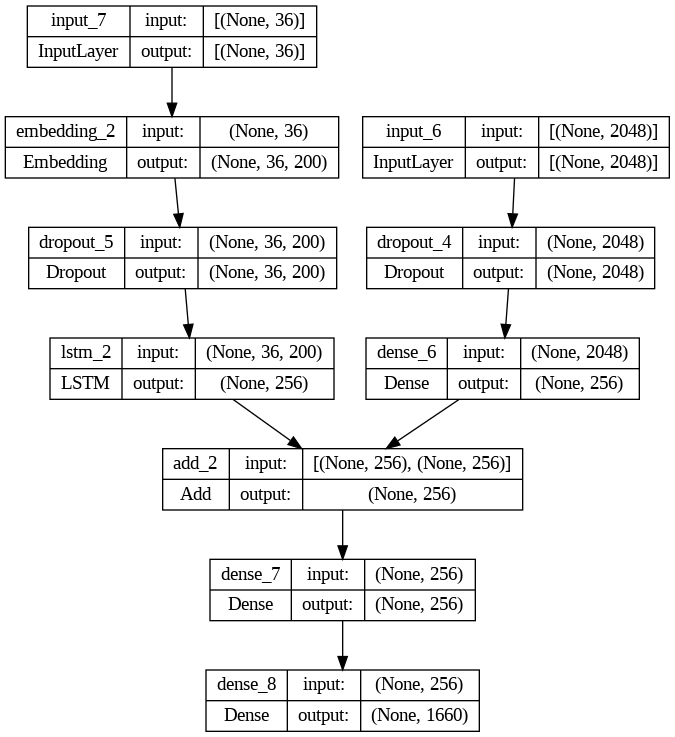

In [66]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
plot_model(model, show_shapes=True)

In [69]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [74]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)

model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
model.save_weights('./model_weights/model_30.5')


Epoch 1/10
2000/2000 [==============================] - 590s 294ms/step - loss: 4.5208
Epoch 2/10
2000/2000 [==============================] - 588s 294ms/step - loss: 3.7248
Epoch 3/10
2000/2000 [==============================] - 587s 294ms/step - loss: 3.4453
Epoch 4/10
2000/2000 [==============================] - 582s 291ms/step - loss: 3.2834
Epoch 5/10
2000/2000 [==============================] - 590s 295ms/step - loss: 3.1663
Epoch 6/10
2000/2000 [==============================] - 586s 293ms/step - loss: 3.0787
Epoch 7/10
2000/2000 [==============================] - 588s 294ms/step - loss: 3.0067
Epoch 8/10
2000/2000 [==============================] - 586s 293ms/step - loss: 2.9474
Epoch 9/10
2000/2000 [==============================] - 586s 293ms/step - loss: 2.8958
Epoch 10/10
2000/2000 [==============================] - 588s 294ms/step - loss: 2.8494


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './model_weights/model_30.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

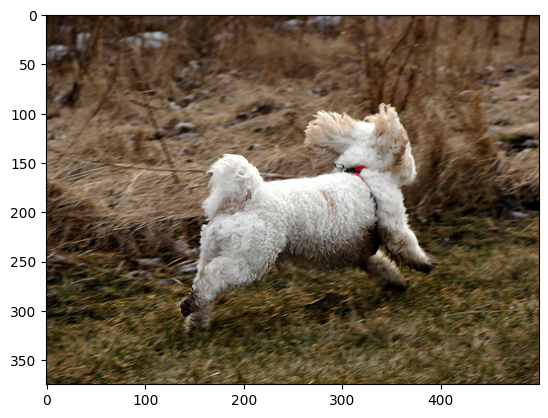

a white dog is running through the grass


In [75]:
images = 'Flickr8k/Flicker8k_Dataset/'
with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
# Với mỗi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi
# sau đó cho vào model để dự đoán từ tiếp theo.
# Ta thêm từ vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq'
# là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
          break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))
